In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from HelperClasses import ClassificationModel, DataHandler, UCRDataset
from pyts.datasets import fetch_ucr_dataset
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.preprocessing import MinMaxScaler
import sklearn
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)


from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

from tslearn.shapelets import LearningShapelets

2025-01-20 13:08:44.454882: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
def scale_dataset(traindata, testdata):
    minmaxscaler = MinMaxScaler()
    minmaxscaler.fit(traindata.reshape(-1, 1))

    scaled_traindata = minmaxscaler.transform(traindata.reshape(-1, 1)).reshape(-1, traindata.shape[1], 1)
    scaled_testdata = minmaxscaler.transform(testdata.reshape(-1, 1)).reshape(-1, testdata.shape[1], 1)
    return scaled_traindata, scaled_testdata


def getAreasFromGradCam(gradcam0, gradcam1, threshold):
    gradcam = np.fmax(gradcam0, gradcam1)
    above_threshold = gradcam > threshold
    areas = []
    start = None
    end = None
    for i, j in enumerate(above_threshold):
        if j & (start is None):
            start = i
        if (not j) & (start is not None):
            end = i
            areas.append([start, end])
            start = None
            end = None
    if start is not None:
        areas.append([start, len(above_threshold)])
    return areas


def getAreasFromLearningShapelets(locations, shapelets):
    return [[[location, location + length] for location, length in zip(sample_locations, [len(s) for s in shapelets])] for sample_locations in locations]


def plot_ts(ts_sample):
    ts, label = ts_sample
    plt.figure(figsize=(10, 4))
    plt.plot(ts, label="Time Series", color='blue')
    plt.title(f"Time Series Plot (Class Label: {label})")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    # Display grid and legend
    plt.grid(False)
    # plt.legend()
    plt.show()

def calculateConfidence(cnn_model, X, y):
    confidences = cnn_model.getConfidences(X)
    return 1 - (float(sum(abs(confidences - cnn_model.enc.transform(y.reshape(-1,1))))[0]) / len(y))

In [6]:
datasets = [{"name": "GunPoint", 1: "Gun", 2: "No Gun"}, 
            {"name": "Coffee", 0: "Robusta", 1: "Arabica"}]

In [7]:
datasets[0]["name"]

'GunPoint'

In [31]:
train_x, test_x, train_y, test_y = fetch_ucr_dataset(datasets[0]["name"], return_X_y = True)
train_x, test_x = scale_dataset(train_x, test_x)

# enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
# train_y=enc1.transform(train_y.reshape(-1,1))
# test_y=enc1.transform(test_y.reshape(-1,1))

In [32]:
train_y

array([2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1,
       1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1,
       2, 2, 1, 2, 1, 2])

In [33]:
datasets[0]["name"]

'GunPoint'

In [34]:
train_x.shape

(50, 150, 1)

# CNN

In [35]:
cnn_model = ClassificationModel(train_x, train_y)

In [36]:
cnn_model.fit(train_x, train_y, num_epochs=100)

Epoch [1/100], Loss: 0.7215
Epoch [2/100], Loss: 0.6948
Epoch [3/100], Loss: 0.6938
Epoch [4/100], Loss: 0.6964
Epoch [5/100], Loss: 0.6853
Epoch [6/100], Loss: 0.6839
Epoch [7/100], Loss: 0.6493
Epoch [8/100], Loss: 0.6082
Epoch [9/100], Loss: 0.5379
Epoch [10/100], Loss: 0.5185
Epoch [11/100], Loss: 0.4975
Epoch [12/100], Loss: 0.4650
Epoch [13/100], Loss: 0.4576
Epoch [14/100], Loss: 0.4505
Epoch [15/100], Loss: 0.4360
Epoch [16/100], Loss: 0.4098
Epoch [17/100], Loss: 0.4685
Epoch [18/100], Loss: 0.4162
Epoch [19/100], Loss: 0.4240
Epoch [20/100], Loss: 0.4236
Epoch [21/100], Loss: 0.4209
Epoch [22/100], Loss: 0.4060
Epoch [23/100], Loss: 0.4193
Epoch [24/100], Loss: 0.3995
Epoch [25/100], Loss: 0.4060
Epoch [26/100], Loss: 0.3939
Epoch [27/100], Loss: 0.3866
Epoch [28/100], Loss: 0.3945
Epoch [29/100], Loss: 0.3870
Epoch [30/100], Loss: 0.3706
Epoch [31/100], Loss: 0.3786
Epoch [32/100], Loss: 0.3856
Epoch [33/100], Loss: 0.3709
Epoch [34/100], Loss: 0.3646
Epoch [35/100], Loss: 0

In [37]:
cnn_model.test(test_x, test_y)

Test Accuracy: 94.67%


In [38]:
cnn_model.classify(1, test_x, test_y) # Index, X, y - Returns predicted Label, true Label

(1, 1)

In [63]:
threshold = 0.85
cnn_areas = []

for x, y in [[train_x, train_y], [test_x, test_y]]:
    dataset_areas = []
    for i in range(len(x)):
        cam_0 = cnn_model.grad_cam(i, x, y, 0)
        cam_1 = cnn_model.grad_cam(i, x, y, 1)
        dataset_areas.append(getAreasFromGradCam(cam_0, cam_1, threshold))
    cnn_areas.append(dataset_areas)

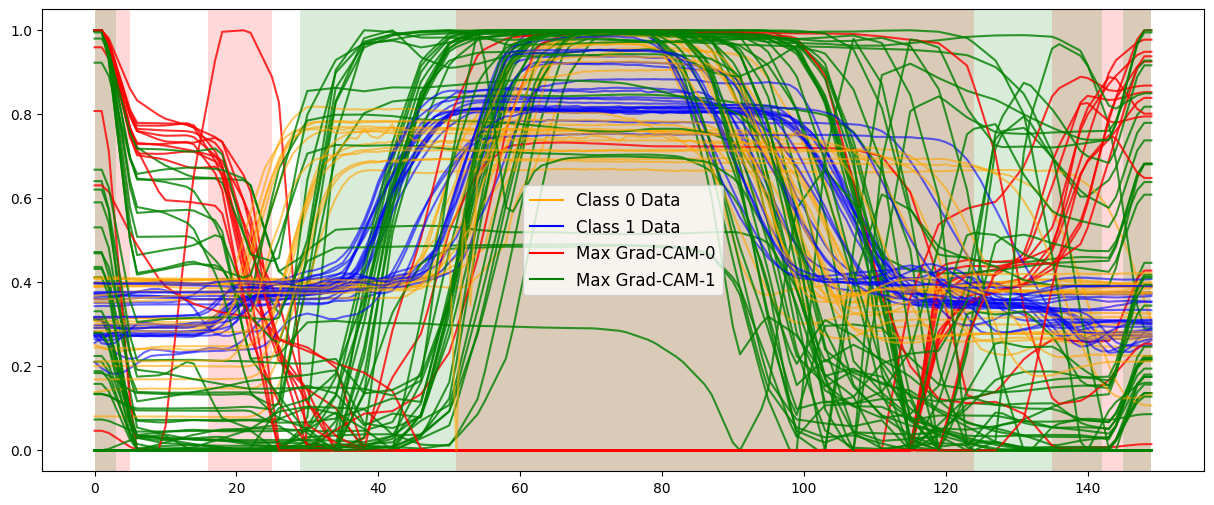

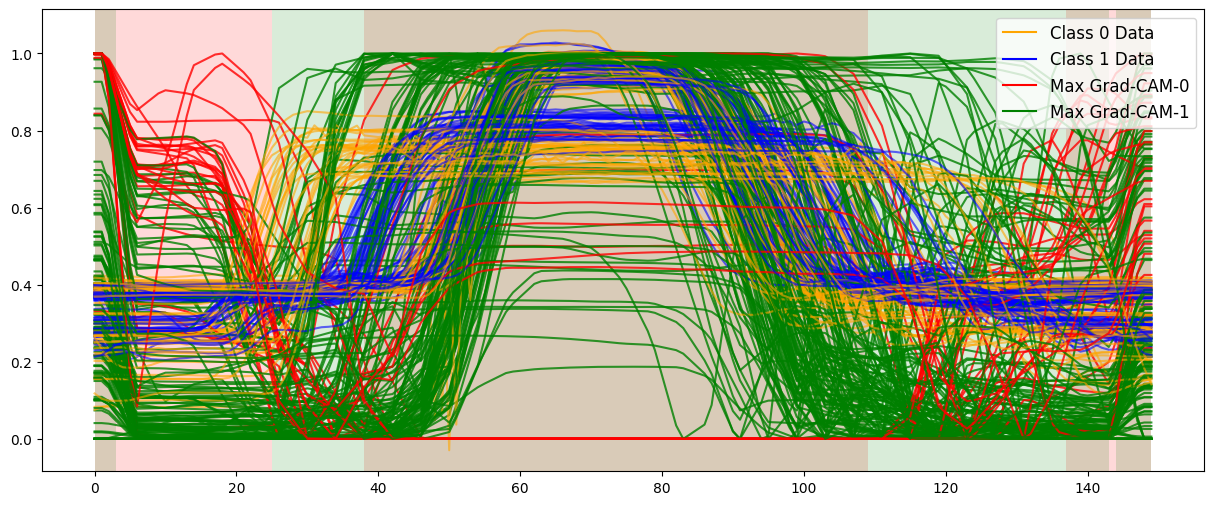

In [64]:
for x, y in [[train_x, train_y], [test_x, test_y]]:

    time_axis = np.arange(test_x.shape[1])
    plt.figure(figsize=(15, 6))

    # Initialize arrays for Grad-CAM maxima
    max_cam_0 = np.zeros_like(time_axis, dtype=float)
    max_cam_1 = np.zeros_like(time_axis, dtype=float)

    for i in range(len(x)):

        # Visualization
        color = 'blue' if y[i] == 1 else 'orange'
        plt.plot(time_axis, x[i], label="Input Time Series", color=color, alpha=0.6)

        # Compute Grad-CAM for class 0
        cam_0 = cnn_model.grad_cam(i, x, y, 0)
        max_cam_0 = np.fmax(max_cam_0, cam_0)
        plt.plot(time_axis, cam_0, alpha=0.8, label="Max Grad-CAM-0", color="red")

        # Compute Grad-CAM for class 1
        cam_1 = cnn_model.grad_cam(i, x, y, 1)
        max_cam_1 = np.fmax(max_cam_1, cam_1)
        plt.plot(time_axis, cam_1, alpha=0.8, label="Max Grad-CAM-1", color="green")


    # Add grey shaded areas where Grad-CAM max values exceed the threshold
    above_threshold_0 = max_cam_0 > threshold
    above_threshold_1 = max_cam_1 > threshold

    for i in range(1, len(time_axis)):
        if above_threshold_0[i]:
            plt.axvspan(time_axis[i - 1], time_axis[i], color='red', alpha=0.15, lw=0)

    for i in range(1, len(time_axis)):
        if above_threshold_1[i]:
            plt.axvspan(time_axis[i - 1], time_axis[i], color='green', alpha=0.15, lw=0)

    # Add title, labels, and legend
    # pltyormalized Value", fontdict = {'fontsize' : 14})

    colors = ['orange', 'blue', 'red', 'green']
    lines = [Line2D([0], [0], color=c) for c in colors]
    labels = ['Class 0 Data', 'Class 1 Data', 'Max Grad-CAM-0', 'Max Grad-CAM-1']
    plt.legend(lines, labels, prop={'size': 12})

    plt.show()


In [14]:
gunpoint_data = DataHandler(train_x, test_x, train_y, test_y)

In [112]:
mcnn_train_x, mcnn_test_x, mcnn_train_y, mcnn_test_y = gunpoint_data.getData(how="zero", all_areas=cnn_areas, invert=False)

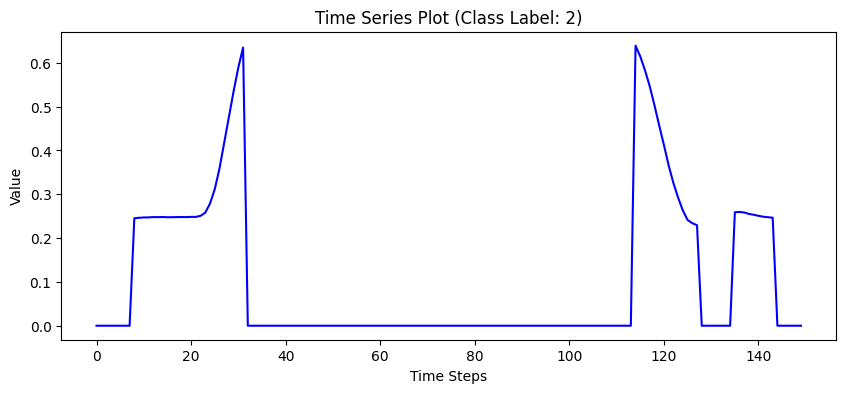

In [96]:
plot_ts([mcnn_train_x[6], mcnn_train_y[6]])

# LearningShapelets

In [100]:
avg_cnn_area_size = np.mean([sum([end - start for start, end in sample_areas]) for dataset_areas in cnn_areas for sample_areas in dataset_areas]) #### Average length of combined CNN areas
avg_cnn_area_size

53.355

In [102]:
number_shapelets = 3
shapelet_length = int(avg_cnn_area_size / number_shapelets)
shapelet_length

17

In [103]:
ls_model = LearningShapelets(n_shapelets_per_size={shapelet_length: number_shapelets}, scale=False)
ls_model.fit(train_x, train_y)

/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


LearningShapelets(n_shapelets_per_size={17: 3})

In [104]:
ls_areas = []
for x, y in [[train_x, train_y], [test_x, test_y]]:
    ls_areas.append(getAreasFromLearningShapelets(ls_model.locate(x), ls_model.shapelets_))

In [116]:
mls_train_x, mls_test_x, mls_train_y, mls_test_y = gunpoint_data.getData(how="zero", all_areas=ls_areas, invert=False)

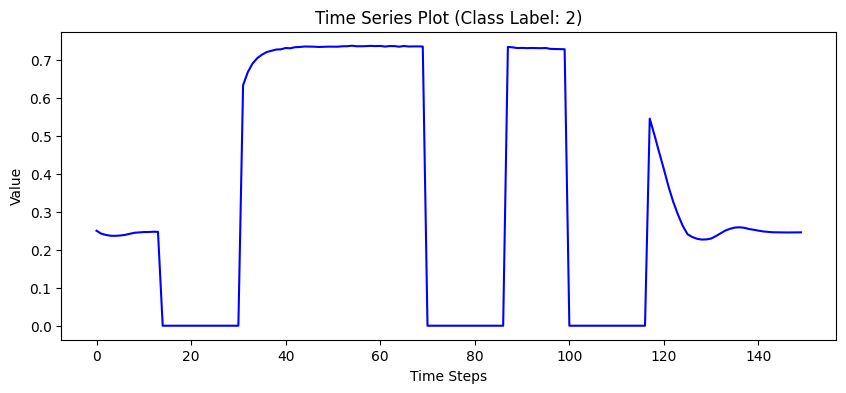

In [110]:
plot_ts([mls_train_x[6], mls_train_y[6]])

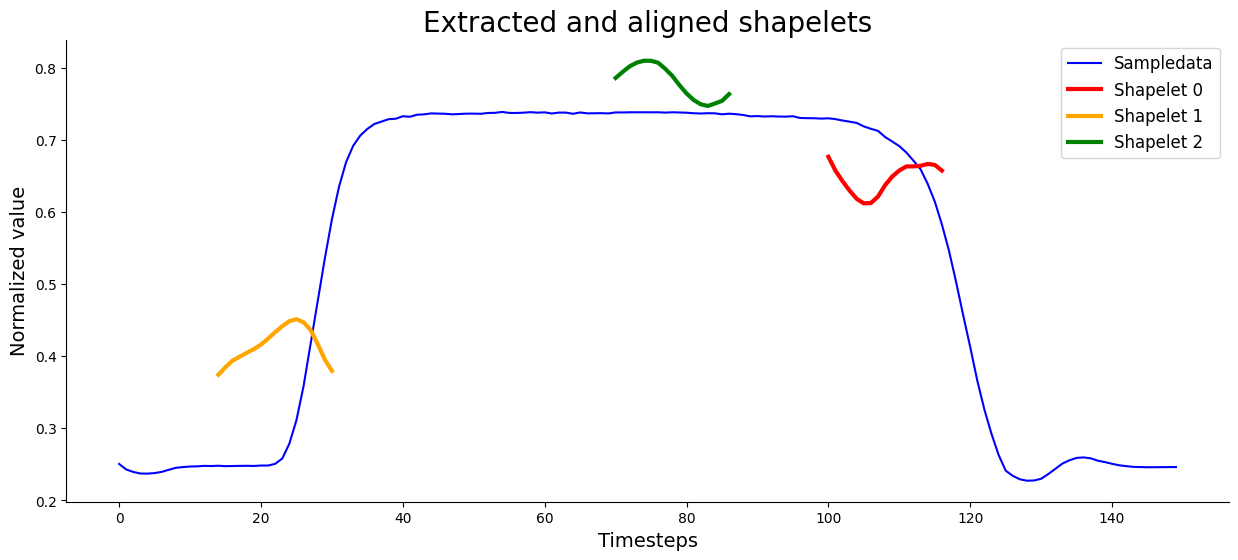

In [111]:
distances = ls_model.transform(train_x) # Do not use since distances come from blackbox model and are not the same as manually calculated distances
predicted_locations = ls_model.locate(train_x)

fig, ax = plt.subplots(figsize=(15, 6))

# Plot the shapelet and align it on the best matched time series. The optimizer
# will often enlarge the shapelet to create a larger gap between the distances
# of both classes. We therefore normalize the shapelet again before plotting.

test_ts_id = 6 #np.argmin(np.sum(distances, axis=1))
id_shap = 0

colors = ["red", "orange", "green", "black", "purple"]

ax.plot(train_x[test_ts_id].ravel(), color='blue', label="Sampledata")
for id_shap in range(len(ls_model.shapelets_)):
    shap = ls_model.shapelets_[id_shap]
    #shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()
    pos = predicted_locations[test_ts_id, id_shap]
    ax.plot(np.arange(pos, pos + len(shap)), shap, linewidth=3, color=colors[id_shap], label=f"Shapelet {id_shap}")
    # ax.axvline(pos, color='k', linestyle='--', alpha=0.25)

ax.set_ylabel("Normalized value", fontdict={'fontsize' : 14})
ax.set_xlabel("Timesteps", fontdict={'fontsize' : 14})
ax.set_title("Extracted and aligned shapelets", fontdict = {'fontsize' : 20})
ax.spines[['right', 'top']].set_visible(False)
ax.legend(prop={'size': 12})

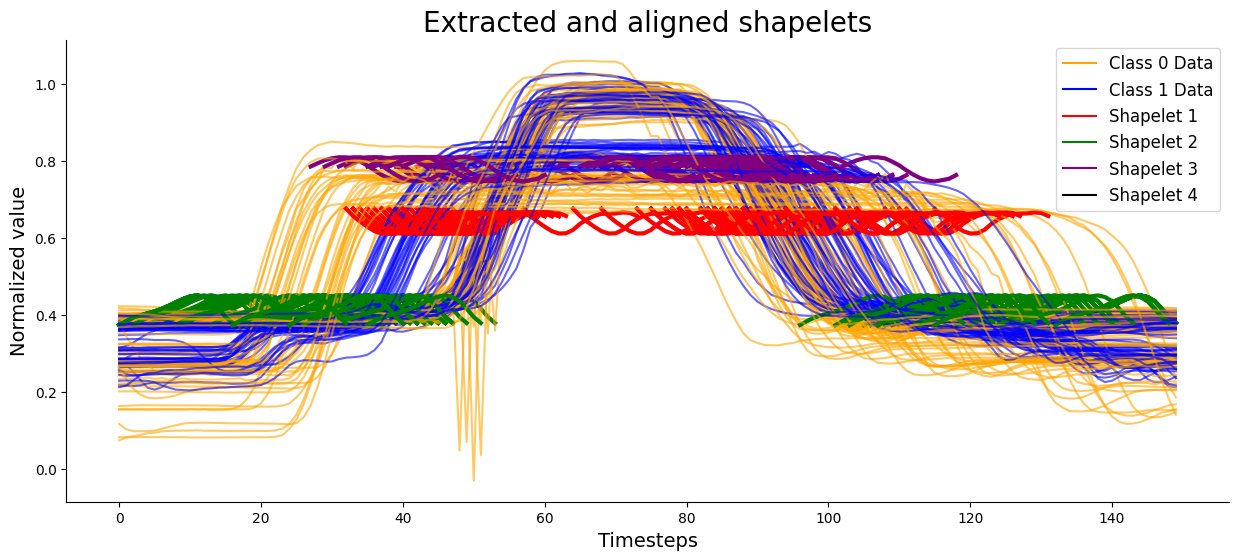

In [108]:
test_dataset = UCRDataset(test_x.astype(np.float32),test_y.astype(np.float32))
predicted_locations = ls_model.locate(test_x)

time_axis = np.arange(train_x.shape[1])
fig, ax = plt.subplots(figsize=(15, 6))

colors = ["red", "green", "purple", "black", "yellow"]

for test_ts_id in range(len(test_dataset)):
    input_tensor = test_dataset[test_ts_id][0]
    label = test_dataset[test_ts_id][1]

    # Visualization
    color = 'blue' if label == 1 else 'orange'
    ax.plot(time_axis, input_tensor, label="Input Time Series", color=color, alpha=0.6)

    for id_shap in range(len(ls_model.shapelets_)):
        shap = ls_model.shapelets_[id_shap]
        #shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()
        pos = predicted_locations[test_ts_id, id_shap]
        ax.plot(np.arange(pos, pos + len(shap)), shap, linewidth=3, color=colors[id_shap])

ax.set_ylabel("Normalized value", fontdict={'fontsize' : 14})
ax.set_xlabel("Timesteps", fontdict={'fontsize' : 14})
ax.set_title("Extracted and aligned shapelets", fontdict = {'fontsize' : 20})
ax.spines[['right', 'top']].set_visible(False)

colors = ['orange', 'blue', 'red', 'green', 'purple', 'black']
lines = [Line2D([0], [0], color=c) for c in colors]
labels = ['Class 0 Data', 'Class 1 Data', 'Shapelet 1', 'Shapelet 2', 'Shapelet 3', 'Shapelet 4']
plt.legend(lines, labels, prop={'size': 12})

# Evaluation

In [118]:
def getMeanConfidences(X):
    confidences = cnn_model.getConfidences(X)
    confidences0 = [confidence for confidence in confidences if confidence[0] > confidence[1]]
    confidences1 = [confidence for confidence in confidences if confidence[0] < confidence[1]]
    return np.mean([confidence[0] for confidence in confidences0]), len(confidences0), np.mean([confidence[1] for confidence in confidences1]), len(confidences1)


In [149]:
confidences = cnn_model.getConfidences(test_x)

confidences0 = [confidence for confidence in confidences if confidence[0] > confidence[1]]
confidences1 = [confidence for confidence in confidences if confidence[0] < confidence[1]]

np.mean([confidence[0] for confidence in confidences0])
np.mean([confidence[1] for confidence in confidences1])

0.9902562

In [122]:
getMeanConfidences(mls_train_x)

(0.9996958, 1, 0.99994135, 49)

In [133]:
mls_train_y

array([2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1,
       1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1,
       2, 2, 1, 2, 1, 2])

In [150]:
cnn_model.test(test_x, test_y)

Test Accuracy: 94.67%


In [141]:
cnn_model.test(mcnn_train_x, mcnn_train_y)

Test Accuracy: 64.00%


In [131]:
cnn_model.classify(-1, train_x, train_y)

(1, 1)

In [159]:

float(sum(abs(confidences - cnn_model.enc.transform(mcnn_test_y.reshape(-1,1))))[0]) / len(mcnn_test_y)

0.0524473342399533

In [158]:
len(test_y)

150

In [166]:
# The confidence of a dataset is 1 minus the average absolute deviation of the first one-hot encoded class and the corresponding probability given by the model
calculateConfidence(cnn_model, test_x, mls_test_y)

0.9475526657600467

# Validation Loop

Variables: 

-threshold for sizes of CNN-areas (number of areas automatically determined by grad-cam)

-number of shapelets (corresponding sizes are determined by size of CNN-areas)

-mode of cancellation (zero, linear or mean)

-inverted areas (true, false) --> can the areas determined as important alone cause good confidence levels?

Compare to original dataset as baseline

In [9]:
datasets = [{"name": "GunPoint", 1: "Gun", 2: "No Gun"}, 
            {"name": "Coffee", 0: "Robusta", 1: "Arabica"}]

In [10]:
thresholds = [0.9, 0.7, 0.5, 0.3, 0.1] ### higher threshold --> smaller areas
shapelet_numbers = [1, 2, 3, 4, 5]
modes_of_cancellation = ["zero", "linear", "mean"]
inverted = [False, True]

In [11]:
results = pd.DataFrame({"dataset": [], "threshold": [], "number_of_shapelets": [], "mode of cancellation": [], "inverted": [], "cnn_train_confidence": [], "cnn_test_confidence": [], "ls_train_confidence": [], "ls_test_confidence": []})

In [12]:
# 1. Prepare Data
for dataset in datasets:

    train_x, test_x, train_y, test_y = fetch_ucr_dataset(dataset["name"], return_X_y = True)
    train_x, test_x = scale_dataset(train_x, test_x)

    data = DataHandler(train_x, test_x, train_y, test_y)


# 2. Train CNN
    train_x, test_x, train_y, test_y = data.getData("raw")
    cnn_model = ClassificationModel(train_x, train_y)
    cnn_model.fit(train_x, train_y, num_epochs=100)

    conftrain = calculateConfidence(cnn_model, train_x, train_y)
    conftest = calculateConfidence(cnn_model, test_x, test_y)

    results = pd.concat([results, pd.DataFrame({"dataset": [dataset["name"]], "threshold": [np.nan], "number_of_shapelets": [np.nan], "mode of cancellation": ["-"], "inverted": ["-"], "cnn_train_confidence": [conftrain], "cnn_test_confidence": [conftest], "ls_train_confidence": [conftrain], "ls_test_confidence": [conftest]})])

# 3. LearningShapelets Loop
    for threshold in thresholds:

        cnn_areas = []
        for x, y in [[train_x, train_y], [test_x, test_y]]:
            dataset_areas = []
            for i in range(len(x)):
                cam_0 = cnn_model.grad_cam(i, x, y, 0)
                cam_1 = cnn_model.grad_cam(i, x, y, 1)
                dataset_areas.append(getAreasFromGradCam(cam_0, cam_1, threshold))
            cnn_areas.append(dataset_areas)

        for shapelet_number in shapelet_numbers:
            
            avg_cnn_area_size = np.mean([sum([end - start for start, end in sample_areas]) for dataset_areas in cnn_areas for sample_areas in dataset_areas]) #### Average length of combined CNN areas
            shapelet_length = int(avg_cnn_area_size / shapelet_number)

            ls_model = LearningShapelets(n_shapelets_per_size={shapelet_length: shapelet_number}, scale=False)
            ls_model.fit(train_x, train_y)
            
            ls_areas = []
            for x, y in [[train_x, train_y], [test_x, test_y]]:
                ls_areas.append(getAreasFromLearningShapelets(ls_model.locate(x), ls_model.shapelets_))

# 4. Cancellation Loop
            for inv in inverted:
                for mode_of_cancellation in modes_of_cancellation:
                    
                    mcnn_train_x, mcnn_test_x, mcnn_train_y, mcnn_test_y = data.getData(how=mode_of_cancellation, all_areas=cnn_areas, invert=inv)
                    mls_train_x, mls_test_x, mls_train_y, mls_test_y = data.getData(how=mode_of_cancellation, all_areas=ls_areas, invert=inv)

                    confmcnntrain = calculateConfidence(cnn_model, mcnn_train_x, mcnn_train_y)
                    confmcnntest = calculateConfidence(cnn_model, mcnn_test_x, mcnn_test_y)
                    confmlstrain = calculateConfidence(cnn_model, mls_train_x, mls_train_y)
                    confmlstest = calculateConfidence(cnn_model, mls_test_x, mls_test_y)

                    results = pd.concat([results, pd.DataFrame({"dataset": [dataset["name"]], "threshold": [threshold], "number_of_shapelets": [shapelet_number], "mode of cancellation": [mode_of_cancellation], "inverted": [inv], "cnn_train_confidence": [confmcnntrain], "cnn_test_confidence": [confmcnntest], "ls_train_confidence": [confmlstrain], "ls_test_confidence": [confmlstest]})])
                    # print("loop")

# 5. Save results to file
results.to_csv("results.csv", header=True, index=False)

Epoch [1/100], Loss: 0.7016
Epoch [2/100], Loss: 0.6890
Epoch [3/100], Loss: 0.8065
Epoch [4/100], Loss: 0.7933
Epoch [5/100], Loss: 0.7933
Epoch [6/100], Loss: 0.7933
Epoch [7/100], Loss: 0.7933
Epoch [8/100], Loss: 0.7615
Epoch [9/100], Loss: 0.7003
Epoch [10/100], Loss: 0.6863
Epoch [11/100], Loss: 0.6399
Epoch [12/100], Loss: 0.5909
Epoch [13/100], Loss: 0.5594
Epoch [14/100], Loss: 0.5109
Epoch [15/100], Loss: 0.5162
Epoch [16/100], Loss: 0.4491
Epoch [17/100], Loss: 0.4577
Epoch [18/100], Loss: 0.4479
Epoch [19/100], Loss: 0.4674
Epoch [20/100], Loss: 0.4245
Epoch [21/100], Loss: 0.4202
Epoch [22/100], Loss: 0.4032
Epoch [23/100], Loss: 0.4166
Epoch [24/100], Loss: 0.4454
Epoch [25/100], Loss: 0.4024
Epoch [26/100], Loss: 0.4140
Epoch [27/100], Loss: 0.3947
Epoch [28/100], Loss: 0.4110
Epoch [29/100], Loss: 0.4045
Epoch [30/100], Loss: 0.3799
Epoch [31/100], Loss: 0.4347
Epoch [32/100], Loss: 0.3890
Epoch [33/100], Loss: 0.4094
Epoch [34/100], Loss: 0.3869
Epoch [35/100], Loss: 0

/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to Fal

/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to Fal

Epoch [1/100], Loss: 0.7080
Epoch [2/100], Loss: 0.6949
Epoch [3/100], Loss: 0.6935
Epoch [4/100], Loss: 0.6948
Epoch [5/100], Loss: 0.6942
Epoch [6/100], Loss: 0.6918
Epoch [7/100], Loss: 0.6883
Epoch [8/100], Loss: 0.6843
Epoch [9/100], Loss: 0.6770
Epoch [10/100], Loss: 0.6558
Epoch [11/100], Loss: 0.6207
Epoch [12/100], Loss: 0.5764
Epoch [13/100], Loss: 0.5094
Epoch [14/100], Loss: 0.4868
Epoch [15/100], Loss: 0.4246
Epoch [16/100], Loss: 0.3987
Epoch [17/100], Loss: 0.3740
Epoch [18/100], Loss: 0.3630
Epoch [19/100], Loss: 0.3639
Epoch [20/100], Loss: 0.3504
Epoch [21/100], Loss: 0.3382
Epoch [22/100], Loss: 0.3300
Epoch [23/100], Loss: 0.3244
Epoch [24/100], Loss: 0.3369
Epoch [25/100], Loss: 0.3279
Epoch [26/100], Loss: 0.3208
Epoch [27/100], Loss: 0.3237
Epoch [28/100], Loss: 0.3270
Epoch [29/100], Loss: 0.3203
Epoch [30/100], Loss: 0.3169
Epoch [31/100], Loss: 0.3165
Epoch [32/100], Loss: 0.3159
Epoch [33/100], Loss: 0.3160
Epoch [34/100], Loss: 0.3159
Epoch [35/100], Loss: 0

/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to Fal

# Analysis of Results

In [15]:
results = pd.read_csv("results.csv")

In [56]:
for dataset in datasets:
    for shapelet_number in shapelet_numbers:
        for mode_of_cancellation in modes_of_cancellation:
            for inv in inverted:
                df = results.loc[(results["dataset"] == dataset["name"]) & (results["inverted"] == str(inv)) & (results["number_of_shapelets"] == shapelet_number) & (results["mode of cancellation"] == mode_of_cancellation)]

                # Create plot
                fig, ax = plt.subplots(figsize=(10, 6))

                # Plot lines
                ax.plot(df["threshold"], df["cnn_test_confidence"], label="Grad-Cam Confidence", marker="o", color="blue")
                ax.plot(df["threshold"], df["ls_test_confidence"], label="Learning Shapelets Confidence", marker="o", color="orange")

                # Customize plot
                ax.set_title("Confidence vs Threshold on Testdata", fontsize=20)
                ax.set_xlabel("Threshold", fontsize=14)
                ax.set_ylabel("Confidence", fontsize=14)
                ax.legend(fontsize=12)
                ax.spines["top"].set_visible(False)
                ax.spines["right"].set_visible(False)
                ax.invert_xaxis()

                dataset_name = dataset["name"]
                plt.savefig(f"images/confidences/conf_vs_thresh_test_{dataset_name}_{shapelet_number}_{mode_of_cancellation}_{inv}.png")
                plt.close(fig)

In [52]:
df = results.loc[(results["dataset"] == "Coffee") & (results["inverted"] == "False") & (results["number_of_shapelets"] == 1) & (results["mode of cancellation"] == "mean")]
df

,dataset,threshold,number_of_shapelets,mode of cancellation,inverted,cnn_train_confidence,cnn_test_confidence,ls_train_confidence,ls_test_confidence
154,Coffee,0.9,1.0,mean,False,0.999443,0.963628,0.999641,0.995932
184,Coffee,0.7,1.0,mean,False,0.988485,0.919704,0.999631,0.988005
214,Coffee,0.5,1.0,mean,False,0.878749,0.771633,0.996469,0.981377
244,Coffee,0.3,1.0,mean,False,0.599783,0.595216,0.966307,0.959504
274,Coffee,0.1,1.0,mean,False,0.512830,0.522967,0.502364,0.507279


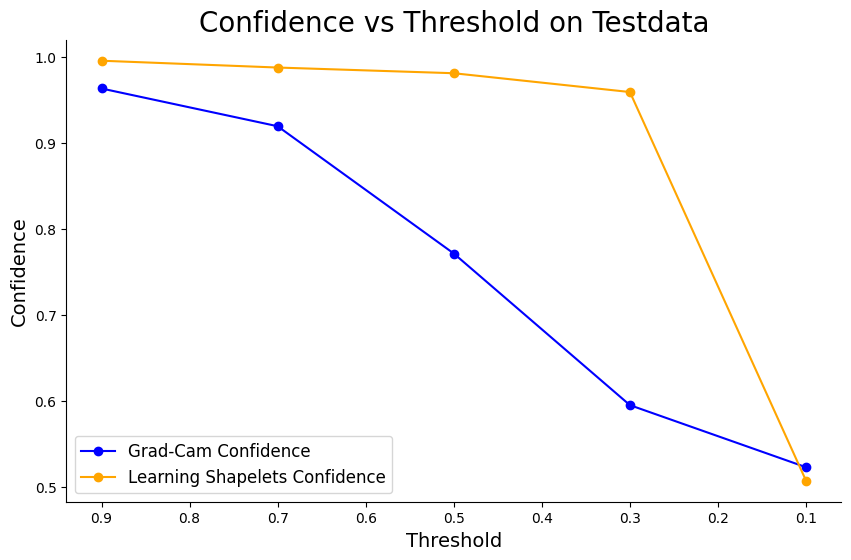

In [53]:
# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot lines
ax.plot(df["threshold"], df["cnn_test_confidence"], label="Grad-Cam Confidence", marker="o", color="blue")
ax.plot(df["threshold"], df["ls_test_confidence"], label="Learning Shapelets Confidence", marker="o", color="orange")

# Customize plot
ax.set_title("Confidence vs Threshold on Testdata", fontsize=20)
ax.set_xlabel("Threshold", fontsize=14)
ax.set_ylabel("Confidence", fontsize=14)
ax.legend(fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.invert_xaxis()

plt.savefig("images/test.png")
plt.show()

In [16]:
results

,dataset,threshold,number_of_shapelets,mode of cancellation,inverted,cnn_train_confidence,cnn_test_confidence,ls_train_confidence,ls_test_confidence
0,GunPoint,NaN,NaN,-,-,0.998662,0.944371,0.998662,0.944371
1,GunPoint,0.9,1.0,zero,False,0.686033,0.705050,0.550722,0.494282
2,GunPoint,0.9,1.0,linear,False,0.998383,0.945729,0.896696,0.833292
3,GunPoint,0.9,1.0,mean,False,0.997249,0.942896,0.933465,0.878791
4,GunPoint,0.9,1.0,zero,True,0.484222,0.465757,0.512121,0.488512
5,GunPoint,0.9,1.0,linear,True,0.665482,0.555502,0.570072,0.498508
6,GunPoint,0.9,1.0,mean,True,0.710536,0.658339,0.578200,0.555433
7,GunPoint,0.9,2.0,zero,False,0.686033,0.705050,0.675207,0.567185
8,GunPoint,0.9,2.0,linear,False,0.998383,0.945729,0.996887,0.960469
9,GunPoint,0.9,2.0,mean,False,0.997249,0.942896,0.935107,0.878712


# Ansatz Dominik

In [ ]:
dataset = datasets[1] ### Hier Datensatz auswählen
train_x, test_x, train_y, test_y = fetch_ucr_dataset(dataset["name"], return_X_y = True)
train_x, test_x = scale_dataset(train_x, test_x)

data = DataHandler(train_x, test_x, train_y, test_y)
dataset["name"]

'Coffee'

In [80]:
cnn_model = ClassificationModel(train_x, train_y)
cnn_model.fit(train_x, train_y, num_epochs=100)

Epoch [1/100], Loss: 0.7605
Epoch [2/100], Loss: 0.6974
Epoch [3/100], Loss: 0.6940
Epoch [4/100], Loss: 0.6931
Epoch [5/100], Loss: 0.6918
Epoch [6/100], Loss: 0.6900
Epoch [7/100], Loss: 0.6885
Epoch [8/100], Loss: 0.6842
Epoch [9/100], Loss: 0.6697
Epoch [10/100], Loss: 0.6687
Epoch [11/100], Loss: 0.6443
Epoch [12/100], Loss: 0.5947
Epoch [13/100], Loss: 0.5578
Epoch [14/100], Loss: 0.4865
Epoch [15/100], Loss: 0.4801
Epoch [16/100], Loss: 0.4447
Epoch [17/100], Loss: 0.4133
Epoch [18/100], Loss: 0.4597
Epoch [19/100], Loss: 0.3896
Epoch [20/100], Loss: 0.4395
Epoch [21/100], Loss: 0.3919
Epoch [22/100], Loss: 0.3580
Epoch [23/100], Loss: 0.3572
Epoch [24/100], Loss: 0.3505
Epoch [25/100], Loss: 0.3623
Epoch [26/100], Loss: 0.3657
Epoch [27/100], Loss: 0.3421
Epoch [28/100], Loss: 0.3438
Epoch [29/100], Loss: 0.3388
Epoch [30/100], Loss: 0.3402
Epoch [31/100], Loss: 0.3272
Epoch [32/100], Loss: 0.3251
Epoch [33/100], Loss: 0.3247
Epoch [34/100], Loss: 0.3337
Epoch [35/100], Loss: 0

In [81]:
ls_model = LearningShapelets(n_shapelets_per_size={20: 3}, scale=False)
ls_model.fit(train_x, train_y)

/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


LearningShapelets(n_shapelets_per_size={20: 3})

In [97]:
ls_areas = []
for x, y in [[train_x, train_y], [test_x, test_y]]:
    ls_areas.append(getAreasFromLearningShapelets(ls_model.locate(x), ls_model.shapelets_))

mls_train_x, mls_test_x, mls_train_y, mls_test_y = data.getData(how="mean", all_areas=ls_areas, invert=False)

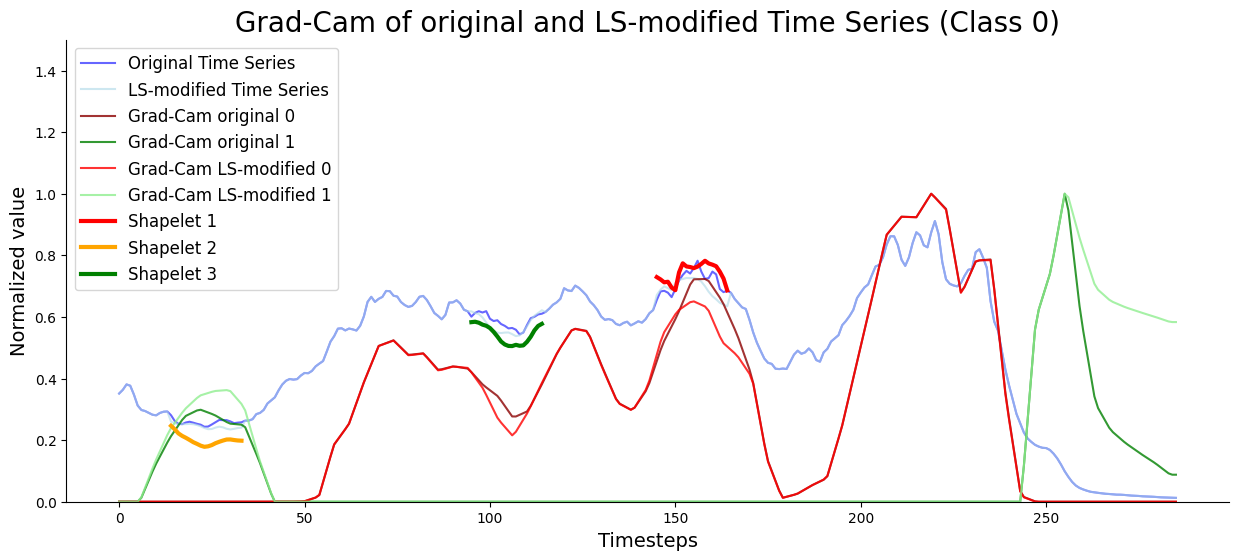

In [98]:
index = 0 ### Hier Sample zur Analyse auswählen

time_axis = np.arange(test_x.shape[1])
plt.figure(figsize=(15, 6))
plt.plot(time_axis, test_x[index], label="Original Time Series", color='blue', alpha=0.6)
plt.plot(time_axis, mls_test_x[index], label="LS-modified Time Series", color='lightblue', alpha=0.6)

cam_0 = cnn_model.grad_cam(index, test_x, test_y, 0)
cam_1 = cnn_model.grad_cam(index, test_x, test_y, 1)
gradcam_original = np.fmax(cam_0, cam_1)
# plt.plot(time_axis, gradcam_original, alpha=0.8, label="Grad-Cam original", color="green")
plt.plot(time_axis, cam_0, alpha=0.8, label="Grad-Cam original 0", color="darkred")
plt.plot(time_axis, cam_1, alpha=0.8, label="Grad-Cam original 1", color="green")


cam_0 = cnn_model.grad_cam(index, mls_test_x, mls_test_y, 0)
cam_1 = cnn_model.grad_cam(index, mls_test_x, mls_test_y, 1)
gradcam_modified = np.fmax(cam_0, cam_1)
# plt.plot(time_axis, gradcam_modified, alpha=0.8, label="Grad-Cam LS-modified", color="lightgreen")
plt.plot(time_axis, cam_0, alpha=0.8, label="Grad-Cam LS-modified 0", color="red")
plt.plot(time_axis, cam_1, alpha=0.8, label="Grad-Cam LS-modified 1", color="lightgreen")

colors = ["red", "orange", "green", "black", "purple"]
predicted_locations = ls_model.locate(test_x)
for id_shap in range(len(ls_model.shapelets_)):
    shap = ls_model.shapelets_[id_shap]
    pos = predicted_locations[index, id_shap]
    plt.plot(np.arange(pos, pos + len(shap)), shap, linewidth=3, color=colors[id_shap], label=f"Shapelet {id_shap+1}")


plt.gca().set_ylim([0, 1.5])
plt.gca().set_ylabel("Normalized value", fontdict={'fontsize' : 14})
plt.gca().set_xlabel("Timesteps", fontdict={'fontsize' : 14})
plt.gca().set_title(f"Grad-Cam of original and LS-modified Time Series (Class {test_y[index]})", fontdict = {'fontsize' : 20})
plt.legend(prop={'size': 12})
plt.gca().spines[['right', 'top']].set_visible(False)
plt.show()

In [71]:
l2_distance = np.sum(np.square(gradcam_original - gradcam_modified))
l2_distance

2.8552847